# StarFast example notebook
This notebook was used to generate all of the images in DMTN-012 (https://github.com/lsst-dm/dmtn-012/blob/master/index.rst), and illustrates the basic uses of StarFast.

For these examples, I am using a reference image at close to zenith (airmass 1.00), and an "observed" image taken at airmass 1.2 for simple image differencing (with and without noise). I have not included any attempt at PSF matching, and so the dipoles for most objects are worse. However, this notebook is examining the effect of Differential Chromatic Refraction (DCR) and I want the effects to be unambiguous. Also, note that the dipoles may be in different directions between very hot and very cool stars! In some cases, standard PSF matching might make the dipoles of very hot and rare objects worse.

In the first section, I use star_sim to generate simulated images with 10,000 stars in the LSST u-band from a catalog of type K - type O stars randomly distributed within a conical volume 1000 light years long and ~4 arcmin wide.

In the second section, I simulate just a single star, but as each spectral type and at u and g bands. 


In [1]:
%matplotlib inline
import os
import cPickle
import galsim 
# import lsst.afw.geom as afwGeom
from lsst.sims.photUtils import matchStar
import numpy as np
import time
from look import look
from StarFast import StarSim
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as cm

First, load in model Kurucz SEDs from sims.photUtils

In [2]:
pickle_file = 'sed_list.pickle'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as dumpfile:
        sed_list = cPickle.load(dumpfile)
else:
    %%capture
    matchStarObj = matchStar()
    sed_list = matchStarObj.loadKuruczSEDs()
    with open(pickle_file, 'wb') as dumpfile:
        cPickle.dump(sed_list, dumpfile, cPickle.HIGHEST_PROTOCOL)

Set up the basic parameters that each simulation will use

In [3]:
seed = 5
dimension = 1024 # number of pixels on a side of the simulation
n_star = 10000
pixel_scale = 0.25 # arcsec / pixel
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star
wavelength_step = 3 # wavelength bin size, in nm
photons_per_adu = 1e4
gsp = galsim.GSParams(folding_threshold=1.0/(dimension), maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=1.0, flux=1, gsparams=gsp)

ref_elevation = 85.0 # in degrees
ref_azimuth = 0.0 # in degrees

obs_elevation = 90.0 - 33.6 # in degrees
obs_azimuth = 20.0 # in degrees

## StarFast simulation setup

First, create the simulation object 'example_sim':

In [4]:
example_sim = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)

Load in a catalog of random sources. This catalog will be used for all of the remaining steps, and the same random catalog can be generated in a new session at a later time by specifying the same seed value.

In [5]:
example_sim.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)

Number and flux contribution of stars of each type:
 [K 5124| 0.30%] [G 3303| 0.58%] [F 1255| 0.85%] [A 274| 2.23%] [B 44| 96.04%] [O 0| 0.00%]


Build a Fourier-space representation of the sky based on the loaded catalog. This model will be used for all of the remaining steps, including simulating effects with variable PSFs such as DCR.

In [6]:
example_sim.simulate()

Time to model 9961 stars: [52.246s | 0.00525s per star]
Time to model 39 bright stars: [21.187s | 0.54327s per star]


## StarFast simulation without noise

StarFast images are created after the simulated model is convolved with a PSF. The models are constructed with multiple image planes with restricted wavelength ranges, so each plane can be convolved with a different PSF and stacked. The only significant computations at this point are the FFTs, so the timing does not depend on the complexity of the source model.

In [7]:
ref_image = example_sim.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image = example_sim.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

FFT timing for 24 DCR planes: [6.407s | 0.267s per plane]
FFT timing for 24 DCR planes: [24.490s | 1.020s per plane]
FFT timing for 24 DCR planes: [5.681s | 0.237s per plane]
FFT timing for 24 DCR planes: [22.585s | 0.941s per plane]


## StarFast simulation with added noise

In [14]:
sky_noise = 0.001
ref_image_addnoise=example_sim.convolve(elevation=ref_elevation, azimuth=ref_azimuth, sky_noise=sky_noise)
obs_image_addnoise=example_sim.convolve(elevation=obs_elevation, azimuth=obs_azimuth, sky_noise=sky_noise)

Adding sky noise with amplitude 0.001000
FFT timing for 24 DCR planes: [8.544s | 0.356s per plane]
FFT timing for 24 DCR planes: [22.850s | 0.952s per plane]
Adding sky noise with amplitude 0.001000
FFT timing for 24 DCR planes: [8.591s | 0.358s per plane]
FFT timing for 24 DCR planes: [23.567s | 0.982s per plane]


## Make a few comparison plots

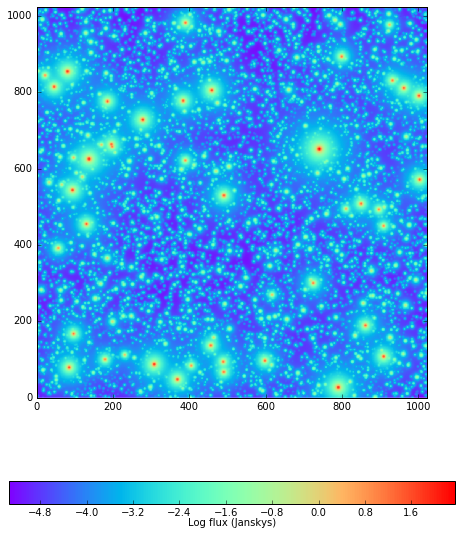

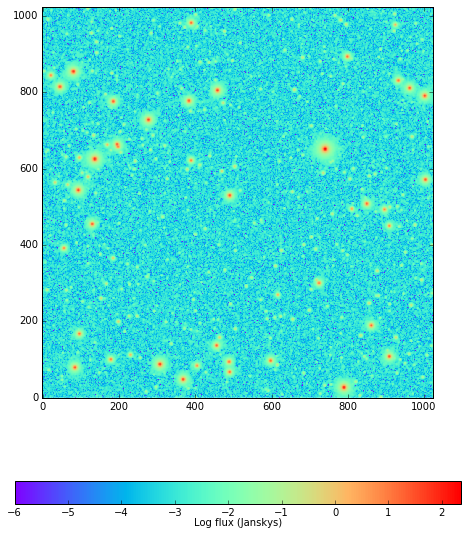

In [15]:
fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image)),-6, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_log.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10, 10), dpi=300)
fig_show = plt.imshow(np.clip(np.log10(np.abs(ref_image_addnoise)),-6, np.Inf), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Log flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_log_addnoise.png',bbox_inches='tight', dpi=300)

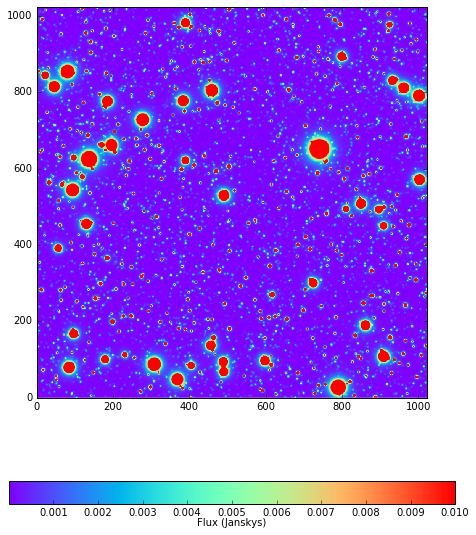

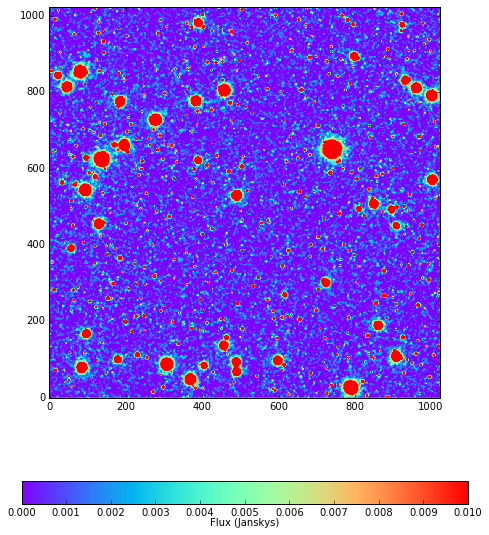

In [16]:
fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise,0,0.01), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('ref_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

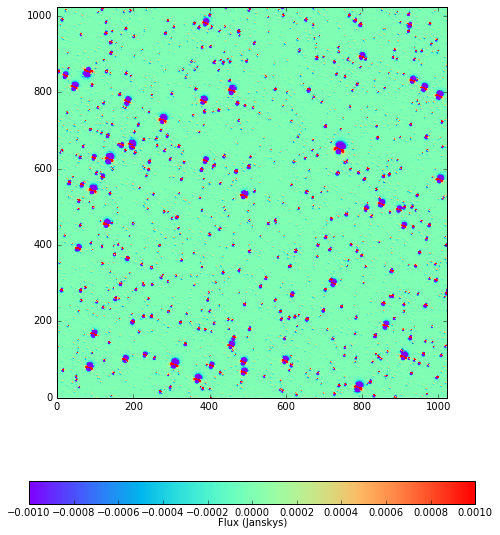

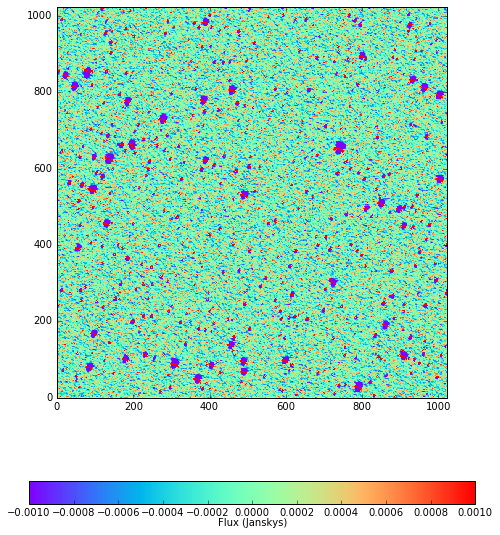

In [17]:
fig = plt.figure(figsize=(10,10), dpi=300)
dcr_color_scale=1e-3
fig_show = plt.imshow(np.clip(ref_image-obs_image,-dcr_color_scale, dcr_color_scale), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('dcr_img10000_linear.png',bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(10,10), dpi=300)
fig_show = plt.imshow(np.clip(ref_image_addnoise-obs_image_addnoise,-dcr_color_scale, dcr_color_scale), interpolation='none', origin='lower', cmap=cm.rainbow)
cbar=plt.colorbar(fig_show, orientation='horizontal', shrink=.8)
cbar.set_label('Flux (Janskys)', labelpad=0, rotation=0)
plt.savefig('dcr_img10000_linear_addnoise.png',bbox_inches='tight', dpi=300)

# Explore the effect of DCR on single stars

In [18]:
seed = 5
dimension = 64 # number of pixels on a side of the simulation
pixel_scale = 0.25 # arcsec / pixel
n_star = 1
wavelength_step = 3 # wavelength bin size, in nm
verbose = False

## u band

Number and flux contribution of stars of each type:
 [O 1| 100.00%]
Time to model 1 bright star: [0.045s]
FFT timing for 24 DCR planes: [0.125s | 0.005s per plane]
FFT timing for 24 DCR planes: [0.115s | 0.005s per plane]


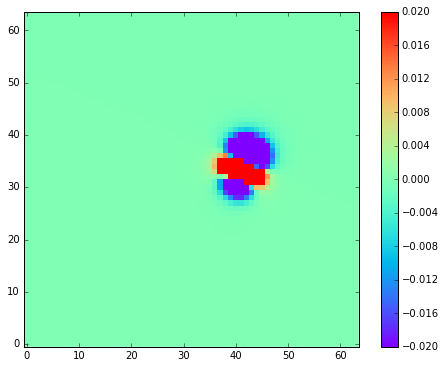

In [19]:
band_name = 'u'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)
sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_O = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_O = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_O - obs_image_u_O, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [B 1| 100.00%]
Time to model 1 bright star: [0.022s]
FFT timing for 24 DCR planes: [0.097s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.120s | 0.005s per plane]


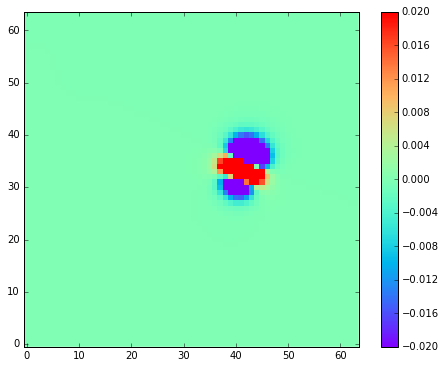

In [27]:
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_B = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_B = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_B - obs_image_u_B, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [A 1| 100.00%]
Time to model 1 bright star: [0.023s]
FFT timing for 24 DCR planes: [0.097s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.089s | 0.004s per plane]


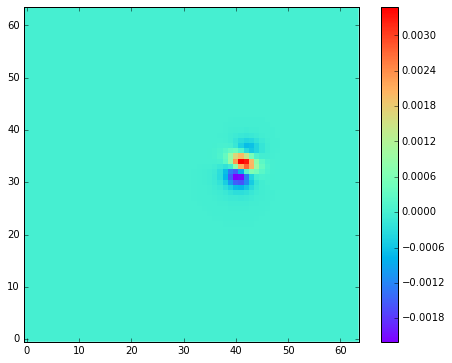

In [28]:
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_A = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_A = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_A - obs_image_u_A, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [F 1| 100.00%]
Time to model 1 bright star: [0.024s]
FFT timing for 24 DCR planes: [0.108s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.091s | 0.004s per plane]


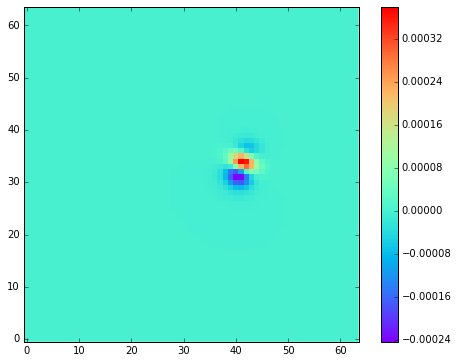

In [29]:
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_F = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_F = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_F - obs_image_u_F, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [G 1| 100.00%]
Time to model 1 bright star: [0.023s]
FFT timing for 24 DCR planes: [0.124s | 0.005s per plane]
FFT timing for 24 DCR planes: [0.100s | 0.004s per plane]


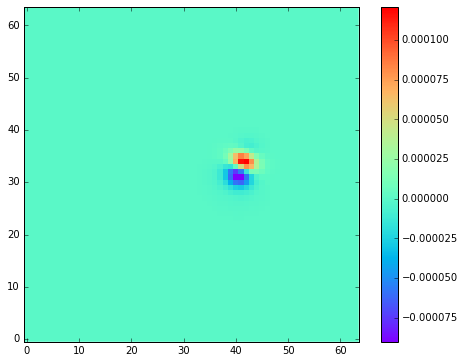

In [30]:
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_G = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_G = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_G - obs_image_u_G, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [K 1| 100.00%]
Time to model 1 bright star: [0.021s]
FFT timing for 24 DCR planes: [0.098s | 0.004s per plane]
FFT timing for 24 DCR planes: [0.091s | 0.004s per plane]


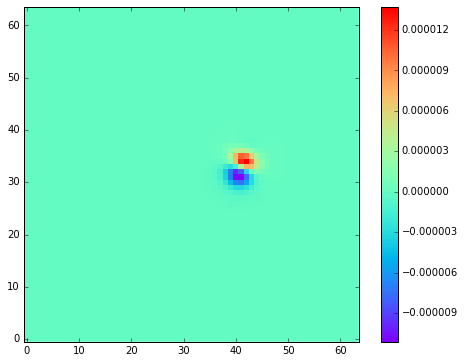

In [31]:
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_u_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_u_band.simulate()
ref_image_u_K = sim_u_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_u_K = sim_u_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_u_K - obs_image_u_K, range=[-0.02, 0.02])

# g band

In [35]:
band_name = 'g'  # vaild options are 'u', 'g', 'r', 'i', 'z', or 'y'
sim_g_band = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension, band_name=band_name,
                      wavelength_step=wavelength_step, sed_list=sed_list)

Number and flux contribution of stars of each type:
 [O 1| 100.00%]
Time to model 1 bright star: [0.051s]
FFT timing for 49 DCR planes: [0.218s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.170s | 0.003s per plane]


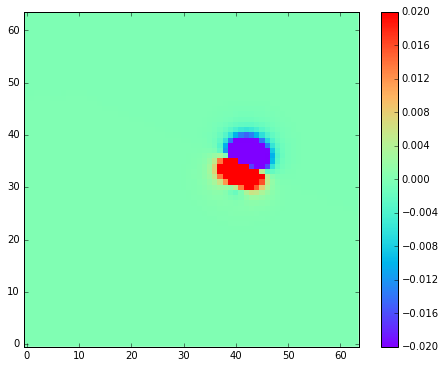

In [36]:
hottest_star='O' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='O' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_O = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_O = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_O - obs_image_g_O, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [B 1| 100.00%]
Time to model 1 bright star: [0.056s]
FFT timing for 49 DCR planes: [0.222s | 0.005s per plane]
FFT timing for 49 DCR planes: [0.174s | 0.004s per plane]


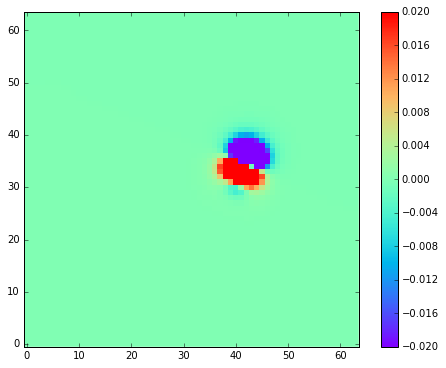

In [37]:
hottest_star='B' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='B' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_B = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_B = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_B - obs_image_g_B, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [A 1| 100.00%]
Time to model 1 bright star: [0.056s]
FFT timing for 49 DCR planes: [0.221s | 0.005s per plane]
FFT timing for 49 DCR planes: [0.170s | 0.003s per plane]


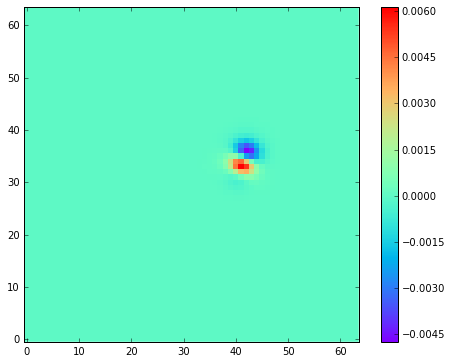

In [38]:
hottest_star='A' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='A' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_A = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_A = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_A - obs_image_g_A, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [F 1| 100.00%]
Time to model 1 bright star: [0.057s]
FFT timing for 49 DCR planes: [0.208s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.172s | 0.004s per plane]


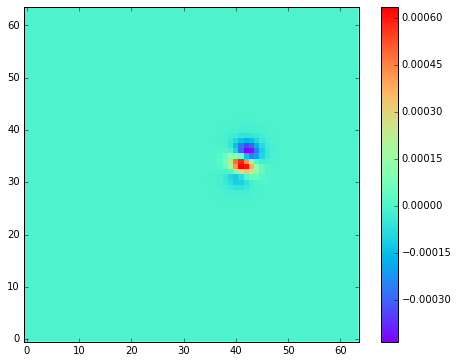

In [39]:
hottest_star='F' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='F' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_F = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_F = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_F - obs_image_g_F, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [G 1| 100.00%]
Time to model 1 bright star: [0.058s]
FFT timing for 49 DCR planes: [0.226s | 0.005s per plane]
FFT timing for 49 DCR planes: [0.171s | 0.003s per plane]


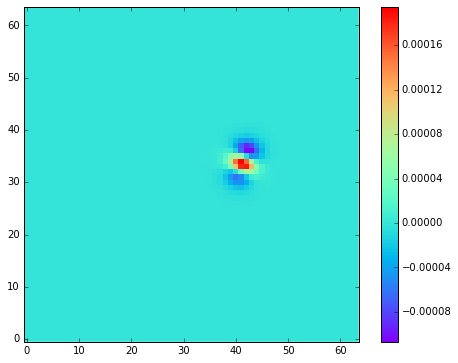

In [40]:
hottest_star='G' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='G' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_G = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_G = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_G - obs_image_g_G, range=[-0.02, 0.02])

Number and flux contribution of stars of each type:
 [K 1| 100.00%]
Time to model 1 bright star: [0.062s]
FFT timing for 49 DCR planes: [0.181s | 0.004s per plane]
FFT timing for 49 DCR planes: [0.173s | 0.004s per plane]


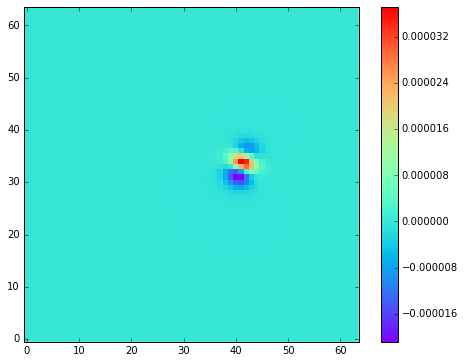

In [42]:
hottest_star='K' # vaild options are None (defaults to 'A') or any stellar type OBAFGKM hotter than coolest star
coolest_star='K' # vaild options are None (defaults to 'M') or any stellar type OBAFGKM cooler than hottest star

sim_g_band.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)
sim_g_band.simulate()

ref_image_g_K = sim_g_band.convolve(elevation=ref_elevation, azimuth=ref_azimuth)
obs_image_g_K = sim_g_band.convolve(elevation=obs_elevation, azimuth=obs_azimuth)

look(ref_image_g_K - obs_image_g_K, range=[-0.02, 0.02])